### Two datasets with a similar motif

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import mubind as mb
import numpy as np
import pandas as pd

import torch
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [56]:
import random
random.seed(500)

n_batch = 3
# batch sizes. Dataset 2 has many times more reads than Dataset 1
batch_sizes = [5, 500, 5000]
train1, test1 = mb.tl.create_simulated_data(motif='GATA', n_batch=n_batch, n_trials=1000, seqlen=10, batch_sizes=batch_sizes) # multiplier=100)
# train2, test2 = mb.tl.create_simulated_data(motif='GATA', batch=1, n_trials=5000, seqlen=25) #  multiplier=5000)

### If treating y data as log, the convergence gets to the GATA motif in small sequences.

In [57]:
train1.dataset.target = np.log(train1.dataset.target)

### Library sizes

<AxesSubplot:xlabel='batch', ylabel='y'>

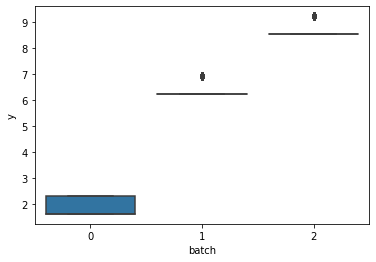

In [58]:
df = pd.DataFrame()
df['y'] = train1.dataset.target
df['batch'] = train1.dataset.batch
sns.boxplot(data=df, x='batch', y='y')

In [59]:
net2 = mb.models.DinucMulti(use_dinuc=False, n_datasets=n_batch, w=7).to(device)
net2.dataset.weight.data.uniform_(1, 1) # initialize weights as ones.

tensor([[1.],
        [1.],
        [1.]])

In [60]:
mononuc = torch.Tensor(train1.dataset.mononuc).to(device)
dinuc = torch.Tensor(train1.dataset.dinuc).to(device)
b = torch.Tensor(train1.dataset.batch).to(torch.int64)
y_true = torch.Tensor(train1.dataset.target)

inputs = (mononuc, dinuc, b)
y_pred = net2(inputs).detach().numpy()

In [61]:
train1.dataset.batch.shape, train1.dataset.mononuc.shape
net2.conv_mono(torch.unsqueeze(torch.Tensor(train1.dataset.mononuc), 1)).shape

torch.Size([990, 1, 1, 8])

In [62]:
optimiser = topti.Adam(net2.parameters(), lr=0.001, weight_decay=0.0001)
criterion = mb.tl.PoissonLoss()
l2 = []
l2 += mb.tl.train_network(net2, train1, device, optimiser, criterion, num_epochs=5000, log_each=100)

Epoch:  1, Loss: -2.785
Epoch: 101, Loss: -4.498
Epoch: 201, Loss: -4.727
Epoch: 301, Loss: -4.764
Epoch: 401, Loss: -4.768
Epoch: 501, Loss: -4.778
Epoch: 601, Loss: -4.775
Epoch: 701, Loss: -4.775
Epoch: 801, Loss: -4.773
Epoch: 901, Loss: -4.783
Epoch: 1001, Loss: -4.776
Epoch: 1101, Loss: -4.770
Epoch: 1201, Loss: -4.782
Epoch: 1301, Loss: -4.773
Epoch: 1401, Loss: -4.773
Epoch: 1501, Loss: -4.789
Epoch: 1601, Loss: -4.770
Epoch: 1701, Loss: -4.769
Epoch: 1801, Loss: -4.763
Epoch: 1901, Loss: -4.763
Epoch: 2001, Loss: -4.782
Epoch: 2101, Loss: -4.772
Epoch: 2201, Loss: -4.779
Epoch: 2301, Loss: -4.765
Epoch: 2401, Loss: -4.772
Epoch: 2501, Loss: -4.774
Epoch: 2601, Loss: -4.773
Epoch: 2701, Loss: -4.771
Epoch: 2801, Loss: -4.781
Epoch: 2901, Loss: -4.783
Epoch: 3001, Loss: -4.780
Epoch: 3101, Loss: -4.776
Epoch: 3201, Loss: -4.779
Epoch: 3301, Loss: -4.770
Epoch: 3401, Loss: -4.778
Epoch: 3501, Loss: -4.764
Epoch: 3601, Loss: -4.781
Epoch: 3701, Loss: -4.763
Epoch: 3801, Loss: -4.7

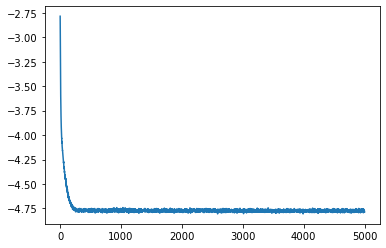

In [63]:
plt.plot(l2)

In [64]:
## check the batch effects
net2.dataset.weight

Parameter containing:
tensor([[0.2942],
        [1.0322],
        [1.4081]], requires_grad=True)

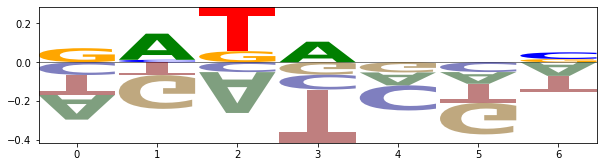

In [65]:
# print(np.exp(net2.log_weight_1.squeeze().cpu().detach().numpy()))
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
#mb.tl.create_logo(net)
#plt.show()
#mb.tl.create_heatmap(net)
import logomaker
weights = net2.conv_mono.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [66]:
from sklearn.metrics import r2_score

In [67]:
net2.dataset.weight

Parameter containing:
tensor([[0.2942],
        [1.0322],
        [1.4081]], requires_grad=True)

### Check the quality of the predictions, across datasets

In [68]:
mononuc = torch.Tensor(train1.dataset.mononuc).to(device)
dinuc = torch.Tensor(train1.dataset.dinuc).to(device)
b = torch.Tensor(train1.dataset.batch).to(torch.int64)
y_true = torch.Tensor(train1.dataset.target)
inputs = (mononuc, dinuc, b)
y_pred = net2(inputs).detach().numpy()

In [69]:
r2_score(y_true, y_pred)

0.9911799234652853

Text(0, 0.5, 'predicted')

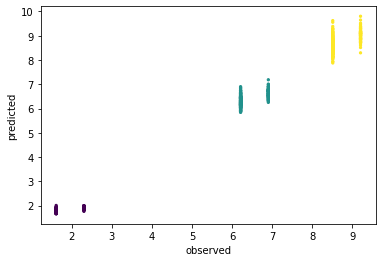

In [74]:
plt.scatter(y_true, y_pred, s=5, c=b)
plt.xlabel('observed')
plt.ylabel('predicted')